In [1]:
import re
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
# 데이터 전처리 및 경기 국면 예측 클래스
class Clock_Predict():
    # 통계청 경기순환시계 데이터를 csv로 정리하는 전처리 과정입니다.
    def crawlingdata_to_csv(self):

        table = {
            'date': [],
            'icon01_x': [], 'icon01_y': [],
            'icon02_x': [], 'icon02_y': [],
            'icon03_x': [], 'icon03_y': [],
            'icon04_x': [], 'icon04_y': [],
            'icon05_x': [], 'icon05_y': [],
            'icon06_x': [], 'icon06_y': [],
            'icon07_x': [], 'icon07_y': [],
            'icon08_x': [], 'icon08_y': [],
            # 'icon09_x': [], 'icon09_y': [],
            # 'icon10_x': [], 'icon10_y': [],
            'icon11_x': [], 'icon11_y': [],
            # 'icon12_x': [], 'icon12_y': [],
            # 'icon13_x': [], 'icon13_y': [],
            # 'icon14_x': [], 'icon14_y': [],
            'icon15_x': [], 'icon15_y': []
            # 'icon16_x': [], 'icon16_y': [],
            # 'icon17_x': [], 'icon17_y': [],
            # 'icon18_x': [], 'icon18_y': [],
            # 'icon19_x': [], 'icon19_y': []
        }

        id_list = ['01', '02', '03', '04', '05', '06', '07', '08', '11', '15']
        
        # KOSIS_data안의 자료는 통계청 경기순환시계 데이터를 JavaScript로 크롤링한 파일입니다.
        for file in tqdm(os.listdir('./data/KOSIS_data')):
            with open('data/KOSIS_data/'+file, 'r', encoding='UTF-8') as f:
                data = f.read()

                p = re.compile('Graphbox[^`]*SVG')
                graphbox = p.findall(data)[0]

                p = re.compile('indicatorDate[^`]*span')
                date = p.findall(graphbox)[0][15:24]
                date = ''.join(date.split())
                table['date'].append(date)

                p = re.compile('<g id="icon0[^>]*>')
                icon_list = p.findall(graphbox)

                for icon in icon_list:
                    id = icon[7:16].split('_')[1]
                    if id in id_list:
                        if 'none' in icon:
                            x, y = None, None
                        else:
                            x, y = map(float, icon[icon.index(
                                '(')+1:icon.index(')')].split())
                        table['icon'+id+'_x'].append(x)
                        table['icon'+id+'_y'].append(y)
                        
        wholex_list = []
        wholey_list = []
        for id in id_list:
            wholex_list.extend(table['icon'+id+'_x'])
            wholey_list.extend(table['icon'+id+'_y'])

        wholex_list = np.array(wholex_list)
        wholey_list = np.array(wholey_list)

        for id in id_list:
            originx_list = np.array(table['icon'+id+'_x'])
            originy_list = np.array(table['icon'+id+'_y'])
            normx_list = []
            normy_list = []
            for i in range(len(originx_list)):
                normx_list.append(
                    (originx_list[i] - wholex_list.mean()) / wholex_list.std())
                normy_list.append(
                    (originy_list[i] - wholey_list.mean()) / wholey_list.std())
            table['icon'+id+'_nx'] = normx_list
            table['icon'+id+'_ny'] = normy_list

        df = pd.DataFrame(table)
        df.to_csv('data/clock_data.csv')
        print("data/clock_data.csv 저장 완료")
    
    # RandomForest Regression을 이용하여 경기순환시계 데이터 10개를 예측하는 과정입니다.
    def clock_predict(self):
        table = pd.read_csv('data/clock_data.csv')
        # 10개의 지표에 대해서
        icon_list = ['01', '02', '03', '04',
                     '05', '06', '07', '08', '11', '15']

        # 4가지 케이스
        # 1. 6개월치를 학습시켜서 1개월 뒤를 예측
        # 2. 6개월치를 학습시켜서 3개월 뒤를 예측
        # 3. 12개월치를 학습시켜서 1개월 뒤를 예측
        # 4. 12개월치를 학습시켜서 3개월 뒤를 에측
        test_list = [
            #             [3,1],
            #             [3,2],
            #             [3,3]
                    [6, 1],
            #             [6,2],
                    [6, 3],
            #             [9,1],
            #             [9,2],
            #             [9,3],
                    [12, 1],
            #             [12,2],
                    [12, 3]
        ]

        # 각 지표의 x축,y축 예측
        axis_list = ['nx', 'ny']

        for i in tqdm(range(len(icon_list))):
            for t in range(len(test_list)):
                for a in range(len(axis_list)):

                    x_data = []
                    y_data = []
                    for j in range(len(table['icon'+icon_list[i]+'_'+axis_list[a]])-(test_list[t][0]+test_list[t][1]-1)):
                        x_data.append(table['icon'+icon_list[i] +
                                            '_'+axis_list[a]][j:j+test_list[t][0]])
                        y_data.append(table['icon'+icon_list[i]+'_'+axis_list[a]]
                                      [j+(test_list[t][0]+test_list[t][1]-1)])

                    x_train, x_test, y_train, y_test = train_test_split(
                        x_data, y_data)

                    model = RandomForestRegressor(n_estimators=10)
                    model.fit(x_train, y_train)
                    y_predict = model.predict(x_data)
                    y_predict = np.append(
                        np.array([None]*(test_list[t][0]+test_list[t][1]-1)), y_predict)

                    table['icon'+icon_list[i]+'_'+axis_list[a] +
                          '_'+str(test_list[t])] = y_predict\

        table.to_csv('data/clock_data_predict.csv')
        print("clock_data_predict.csv 저장 완료")

    # K-means Clustering을 사용하여 10개의 경기지표 예측값으로 경기국면을 라벨링합니다. 
    def phase_clustering(self):
        # 랜덤포레스트 모델로 예측한 국면 지표 예측값 입력
        economic = pd.read_csv('data/clock_data_predict_modify.csv')

        # [12, 1] 12개월 데이터로 한 달 후의 데이터 예측값
        economic_use = economic[['icon01_nx_[12, 1]', 'icon01_ny_[12, 1]', 'icon02_nx_[12, 1]', 'icon02_ny_[12, 1]',
                                 'icon03_nx_[12, 1]', 'icon03_ny_[12, 1]', 'icon04_nx_[12, 1]', 'icon04_ny_[12, 1]',
                                 'icon05_nx_[12, 1]', 'icon05_ny_[12, 1]', 'icon06_nx_[12, 1]', 'icon06_ny_[12, 1]',
                                 'icon07_nx_[12, 1]', 'icon07_ny_[12, 1]', 'icon08_nx_[12, 1]', 'icon08_ny_[12, 1]',
                                 'icon11_nx_[12, 1]', 'icon11_ny_[12, 1]', 'icon15_nx_[12, 1]', 'icon15_ny_[12, 1]']]

        # k-means clustering을 통해 각 경기 국면에 대한 라벨링
        clusters = 6
        kmeans = KMeans(n_clusters=clusters)
        kmeans.fit(economic_use)

        # 경기 국면 라벨링 데이터 엑셀로 출력
        economic_use['cluster_label'] = kmeans.labels_
        economic_use['date'] = economic['date']
        economic_use.to_csv('data/clock_data_predict_label.csv')
        print("data/clock_data_predict_label.csv 저장 완료")

In [3]:
predic = pd.read_csv('data/clock_data_final.csv', low_memory=False)
indexing_predic = predic.set_index('date') 

bt = pd.read_csv('data/data_d.csv')
NaN_processing_bt = bt.fillna(0) 
indexing_bt = NaN_processing_bt.set_index('date') 

# K-means 국면 예측값을 활용하여 국면별 포트폴리오 자산별 최적 비중을 계산하는 클래스
class Get_weight:

    def __init__(self):

        while(1):
            print('이 작업은 2003년 3월부터 ')
            try:
                self.G = int(input(
                    "Backtesting 하고싶은 '국면'을 숫자로 입력합니다. \n회복 : 0 \n상승 : 1 \n둔화 : 2 \n하강 : 3 \n중에서 하나를 입력하세요. : "))
                if self.G == 0:
                    print('\n[회복 국면을 선택하셨습니다.]')
                    break
                elif self.G == 1:
                    print('\n[상승 국면을 선택하셨습니다.]')
                    break
                elif self.G == 2:
                    print('\n[둔화 국면을 선택하셨습니다.]')
                    break
                elif self.G == 3:
                    print('\n[하강 국면을 선택하셨습니다.]')
                    break
                else:
                    print('\n--------------------')
                    print("숫자를 다시 입력해주세요")
                    print('--------------------\n')
                    continue
            except:
                print('\n--------------------')
                print("숫자를 다시 입력해주세요")
                print('--------------------\n')
                continue



        while (1):
            try:

                self.H = int(input("\n이제 'Risk' 를 입력합니다. \nAverse : 0 \nNeutral : 1 \nLover : 2 \n중에서 하나를 입력하세요. : "))
                if self.H == 0:
                    print('\n[Risk Averse를 선택하셨습니다.]\n')
                    break
                elif self.H == 1:
                    print('\n[Risk Neutral을 선택하셨습니다.]\n')
                    break
                elif self.H == 2:
                    print('\n[Risk Lover를 선택하셨습니다.]\n')
                    break
                else:
                    print('\n--------------------')
                    print("숫자를 다시 입력해주세요")
                    print('--------------------\n')
                    continue
            except:
                print('\n--------------------')
                print("숫자를 다시 입력해주세요")
                print('--------------------\n')
                continue

    # 입력한 국면별 MVF를 통해서 sharpe ratio, return, vol, mdd를 최적화하는 비중을 계산합니다. 
    def Run(self): 
        self.Colected_Data = pd.DataFrame()
        array_for_bt = pd.DataFrame()

        if self.G == 0:
            self.Colected_Data = self.Select_Date('2003-08', '2004-02', self.Colected_Data)  # 회복
            self.Colected_Data = self.Select_Date('2005-06', '2006-02', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2006-09', '2006-12', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2009-02', '2009-09', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2009-09', '2010-06', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2013-08', '2014-02', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2016-12', '2017-07', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2020-07', '2020-11', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2020-11', '2021-03', self.Colected_Data)
        elif self.G == 1:
            self.Colected_Data = self.Select_Date('2004-02', '2004-04', self.Colected_Data)  # 상승
            self.Colected_Data = self.Select_Date('2006-12', '2008-04', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2010-06', '2011-09', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2017-07', '2018-06', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2021-03', '2021-07', self.Colected_Data)
        elif self.G == 2:
            self.Colected_Data = self.Select_Date('2003-02', '2003-05', self.Colected_Data)  # 둔화
            self.Colected_Data = self.Select_Date('2004-04', '2004-12', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2006-01', '2006-08', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2008-04', '2008-08', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2011-09', '2012-09', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2014-02', '2015-06', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2018-06', '2019-01', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2019-12', '2020-02', self.Colected_Data)
        elif self.G == 3:
            self.Colected_Data = self.Select_Date('2003-04', '2003-08', self.Colected_Data)  # 하강
            self.Colected_Data = self.Select_Date('2004-12', '2005-06', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2008-08', '2009-02', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2012-09', '2013-08', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2015-06', '2016-11', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2019-01', '2019-11', self.Colected_Data)
            self.Colected_Data = self.Select_Date('2020-02', '2020-06', self.Colected_Data)

        else:
            print("Error\n")
            self.__init__()

        if self.H == 0:

            array_for_bt = self.Backtesting_averse(self.Colected_Data)
            self.Analysis(array_for_bt)
            self.Scatter(array_for_bt)

        elif self.H == 1:
            array_for_bt = self.Backtesting_neutral(self.Colected_Data)
            self.Analysis(array_for_bt)
            self.Scatter(array_for_bt)

        elif self.H == 2:
            array_for_bt = self.Backtesting_lover(self.Colected_Data)
            self.Analysis(array_for_bt)
            self.Scatter(array_for_bt)
        else:
            print("Error\n")
            self.__init__()



    # 구간 데이터 모으는 함수
    def Select_Date(self, Start, End, Dataframe): 

        total = indexing_bt.loc['{}'.format(Start):'{}'.format(End)]

        self.Dataframe = pd.concat([Dataframe, total])  
        return self.Dataframe
    
    # Risk-averse 백테스팅 함수 
    def Backtesting_averse(self, Data):
        self.array_bt_all = pd.DataFrame()
        t = 0
        for a in range(0, 16):
            print("Backtesting Risk Averse {} % percent..".format(int(a * 6.7)))
            a += 5
            for b in range(0, 16):
                b += 5
                if a + b > 35:
                    break
                for c in range(0, 16):
                    c += 5
                    if a + b + c > 40:
                        break
                    for d in range(0, 16):
                        d += 5
                        if a + b + c + d > 45:
                            break

                        e = 50 - a - b - c - d
                        if e > 20:
                            break

                        random_weight = np.array([a, b, c, d, e]) * 2

                        kospi = random_weight[0]
                        k10bond = random_weight[1]
                        k5bond = random_weight[2]
                        gold = random_weight[3]
                        commodity = random_weight[4]

                        list_for_mdd = []
                        list_for_var = []

                        R = None

                        for i in range(0, len(Data)):
                            gold = gold * (1 + Data['gold'][i]) 
                            k10bond = k10bond * (1 + Data['k10bond'][i])
                            k5bond = k5bond * (1 + Data['k5bond'][i])
                            kospi = kospi * (1 + Data['kospi'][i])
                            commodity = commodity * (1 + Data['commodity'][i])

                            sum_for_mdd_var = gold + k10bond + k5bond + kospi + commodity
                            list_for_mdd.append(sum_for_mdd_var)

                            if R:  
                                r = (sum_for_mdd_var - R) / R * 100
                                list_for_var.append(r)

                            R = sum_for_mdd_var

                        rate_of_return = (gold + k10bond + k5bond + kospi + commodity - 100) 

                        Max = max(list_for_mdd)
                        Min = min(list_for_mdd)
                        Mdd = (Min - Max) / Max * 100

                        var_portfolio = np.array(list_for_var).var()  
                        Volatility_standard_deviation = np.sqrt(var_portfolio)
                        Sharpe_ratio = (rate_of_return / 100) / Volatility_standard_deviation  

                        infor_dataframe = pd.DataFrame(
                            {'Return %': [round(rate_of_return, 4)], 'MDD %': [round(Mdd, 4)],
                             'Sharpe': [round(Sharpe_ratio, 4)],
                             'Volatility': [round(Volatility_standard_deviation, 4)],
                             'kospi': [random_weight[0]], 'k10bond': [random_weight[1]],
                             'k5bond': [random_weight[2]], 'gold': [random_weight[3]], 'commodity': [random_weight[4]]},
                            index=[t])

                        self.array_bt_all = pd.concat([self.array_bt_all, infor_dataframe])

                        t += 1

        return self.array_bt_all
    
    # Risk-neutral 백테스팅 함수 
    def Backtesting_neutral(self, Data):
        self.array_bt_all = pd.DataFrame()
        t = 0
        for a in range(0, 21):  
            print("Backtesting Risk Neutral {} % percent..".format(a*5))
            a += 5
            for b in range(0, 21):
                b += 5
                if a + b > 35:
                    break
                for c in range(0, 21):
                    c += 5
                    if a + b + c > 40:
                        break
                    for d in range(0, 21):
                        d += 5
                        if a + b + c + d > 45:
                            break
                        e = 50 - a - b - c - d

                        if e > 25:
                            break

                        random_weight = np.array([a, b, c, d, e]) * 2

                        kospi = random_weight[0]
                        k10bond = random_weight[1]
                        k5bond = random_weight[2]
                        gold = random_weight[3]
                        commodity = random_weight[4]

                        list_for_mdd = []
                        list_for_var = []

                        R = None

                        for i in range(0, len(Data)):
                            gold = gold * (1 + Data['gold'][i])  
                            k10bond = k10bond * (1 + Data['k10bond'][i])
                            k5bond = k5bond * (1 + Data['k5bond'][i])
                            kospi = kospi * (1 + Data['kospi'][i])
                            commodity = commodity * (1 + Data['commodity'][i])

                            sum_for_mdd_var = gold + k10bond + k5bond + kospi + commodity
                            list_for_mdd.append(sum_for_mdd_var)

                            if R:
                                r = (sum_for_mdd_var - R) / R * 100
                                list_for_var.append(r)

                            R = sum_for_mdd_var

                        rate_of_return = (gold + k10bond + k5bond + kospi + commodity - 100) 

                        Max = max(list_for_mdd)
                        Min = min(list_for_mdd)
                        Mdd = (Min - Max) / Max * 100

                        var_portfolio = np.array(list_for_var).var() 
                        Volatility_standard_deviation = np.sqrt(var_portfolio)
                        Sharpe_ratio = (rate_of_return / 100) / Volatility_standard_deviation  

                        infor_dataframe = pd.DataFrame(
                            {'Return %': [round(rate_of_return, 4)], 'MDD %': [round(Mdd, 4)],
                             'Sharpe': [round(Sharpe_ratio, 4)],
                             'Volatility': [round(Volatility_standard_deviation, 4)],
                             'kospi': [random_weight[0]], 'k10bond': [random_weight[1]],
                             'k5bond': [random_weight[2]], 'gold': [random_weight[3]], 'commodity': [random_weight[4]]},
                            index=[t])

                        self.array_bt_all = pd.concat([self.array_bt_all, infor_dataframe])

                        t += 1

        return self.array_bt_all
    
    # Risk-lover 백테스팅 함수 
    def Backtesting_lover(self, Data):
        self.array_bt_all = pd.DataFrame()
        t = 0
        for a in range(0, 26):
            print("Backtesting Risk Lover {} % percent..".format(int(a * 4)))
            a += 5
            for b in range(0, 26):
                b += 5
                if a + b > 35:
                    break
                for c in range(0, 26):
                    c += 5
                    if a + b + c > 40:
                        break
                    for d in range(0, 26):
                        d += 5
                        if a + b + c + d > 45:
                            break

                        e = 50 - a - b - c - d
                        if e > 30:
                            break

                        random_weight = np.array([a, b, c, d, e]) * 2

                        kospi = random_weight[0]
                        k10bond = random_weight[1]
                        k5bond = random_weight[2]
                        gold = random_weight[3]
                        commodity = random_weight[4]

                        list_for_mdd = []
                        list_for_var = []

                        R = None

                        for i in range(0, len(Data)):
                            gold = gold * (1 + Data['gold'][i]) 
                            k10bond = k10bond * (1 + Data['k10bond'][i])
                            k5bond = k5bond * (1 + Data['k5bond'][i])
                            kospi = kospi * (1 + Data['kospi'][i])
                            commodity = commodity * (1 + Data['commodity'][i])

                            sum_for_mdd_var = gold + k10bond + k5bond + kospi + commodity
                            list_for_mdd.append(sum_for_mdd_var)

                            if R:
                                r = (sum_for_mdd_var - R) / R * 100
                                list_for_var.append(r)

                            R = sum_for_mdd_var

                        rate_of_return = (gold + k10bond + k5bond + kospi + commodity - 100) 

                        Max = max(list_for_mdd)
                        Min = min(list_for_mdd)
                        Mdd = (Min - Max) / Max * 100

                        var_portfolio = np.array(list_for_var).var() 
                        Volatility_standard_deviation = np.sqrt(var_portfolio)
                        Sharpe_ratio = (rate_of_return / 100) / Volatility_standard_deviation  

                        infor_dataframe = pd.DataFrame(
                            {'Return %': [round(rate_of_return, 4)], 'MDD %': [round(Mdd, 4)],
                             'Sharpe': [round(Sharpe_ratio, 4)],
                             'Volatility': [round(Volatility_standard_deviation, 4)],
                             'kospi': [random_weight[0]], 'k10bond': [random_weight[1]],
                             'k5bond': [random_weight[2]], 'gold': [random_weight[3]], 'commodity': [random_weight[4]]},
                            index=[t])

                        self.array_bt_all = pd.concat([self.array_bt_all, infor_dataframe])

                        t += 1

        return self.array_bt_all

    # sharpe ratio, return, vol, mdd 
    def Analysis(self, Dataframe):
        
        print('----------Sharpe Max------------')
        print(Dataframe.loc[Dataframe.idxmax()[2]])

        print('----------Return Max------------')
        print(Dataframe.loc[Dataframe.idxmax()[0]])

        print('----------Volatility Min------------')
        print(Dataframe.loc[Dataframe.idxmin()[3]])
        
        print('----------MDD Min------------')
        print(Dataframe.loc[Dataframe.idxmax()[1]])

        
    # MVF를 그리는 함수     
    def Scatter(self, Dataframe):

        plt.subplots(figsize=[10, 10])
        scatter1 = plt.scatter(Dataframe['Volatility'], Dataframe['Return %'], marker='o', s=10, alpha=0.5)  # 알파는 투명도

        plt.scatter(Dataframe.iloc[Dataframe.idxmax()[2], 3], Dataframe.iloc[Dataframe.idxmax()[2], 0], marker='x',
                    c='red', s=15)
        plt.annotate('Sharpe Max', fontsize=10,
                     xy=(Dataframe.iloc[Dataframe.idxmax()[2], 3], Dataframe.iloc[Dataframe.idxmax()[2], 0]), xytext=(
            Dataframe.iloc[Dataframe.idxmax()[2], 3] - 0.03, Dataframe.iloc[Dataframe.idxmax()[2], 0] + 0.15))

        plt.scatter(Dataframe.iloc[Dataframe.idxmin()[3], 3], Dataframe.iloc[Dataframe.idxmin()[3], 0], marker='x',
                    c='red', s=15)
        plt.annotate('Volatility Min', fontsize=10,
                     xy=(Dataframe.iloc[Dataframe.idxmin()[3], 3], Dataframe.iloc[Dataframe.idxmin()[3], 0]),
                     xytext=(Dataframe.iloc[Dataframe.idxmin()[3], 3] - 0.03,
                             Dataframe.iloc[Dataframe.idxmin()[3], 0] + 0.15), )

        plt.scatter(Dataframe.iloc[Dataframe.idxmax()[0], 3], Dataframe.iloc[Dataframe.idxmax()[0], 0], marker='x',
                    c='red',
                    s=15)
        plt.annotate('Return Max', fontsize=10,
                     xy=(Dataframe.iloc[Dataframe.idxmax()[0], 3], Dataframe.iloc[Dataframe.idxmax()[0], 0]), xytext=(
                Dataframe.iloc[Dataframe.idxmax()[0], 3] - 0.03, Dataframe.iloc[Dataframe.idxmax()[0], 0] + 0.15))

        plt.scatter(Dataframe.iloc[Dataframe.idxmax()[1], 3], Dataframe.iloc[Dataframe.idxmax()[1], 0], marker='x',
                    c='red',
                    s=15)

        plt.annotate('MDD Min', fontsize=10,
                     xy=(Dataframe.iloc[Dataframe.idxmax()[1], 3], Dataframe.iloc[Dataframe.idxmax()[1], 0]), xytext=(
                Dataframe.iloc[Dataframe.idxmax()[1], 3] - 0.03, Dataframe.iloc[Dataframe.idxmax()[1], 0] + 0.15))


        plt.xlabel('Volatility')
        plt.ylabel('Return %')
        plt.show()

        
# 대표적인 포트폴리오들과 예측 국면별 자산 최적 비중을 실행한 백테스팅 결과를 비교
class Strategy:

    def __init__(self):
        while (1):
            try:
                print("\n전략 실행은 2003-03 부터 가능합니다. YYYY-MM 양식을 지켜주세요")
                self.S = input("전략실행 시작 연-월을 입력하세요. 월초부터 실행합니다. ex)2003-03 : ")
                print("\n전략 실행은 2021-05 까지 가능합니다. YYYY-MM 양식을 지켜주세요")
                pre_E = input("전략실행 종료 연-월을 입력하세요. 월말까지 실행합니다. ex)2021-05 : ")
                self.E = ''.join(indexing_predic.index[(predic.index[predic.index[predic['date'] == pre_E]] + 1).tolist()])
            except:
                print('\n---------------------------------------------------')
                print(" 날짜입력 오류입니다. 1월인경우 01로 입력 바랍니다.")
                print('---------------------------------------------------\n')
                print("아무키나 입력하면 시작시간부터 다시 설정합니다.")
                self.Q = input("혹시 프로그램을 종료하고 싶다면 q를 입력해주세요.(대소문자 모두 가능) : ")
                print('\n\n\n')
                if self.Q == 'q' or self.Q == 'Q':
                    print('\n프로그램을 종료합니다. 감사합니다.')
                    exit()
                else:
                    continue

            self.predic12_1 = indexing_predic.loc[:, 'economic_cycle_12_1']
            self.predic12_1_set_SE = indexing_predic.loc[self.S : self.E]

            if self.predic12_1_set_SE.empty:
                print('\n---------------------------------------------------')
                print(" 날짜입력 오류입니다. 1월인경우 01로 입력 바랍니다.")
                print('---------------------------------------------------\n')
                print("아무키나 입력하면 시작시간부터 다시 설정합니다.")
                self.Q = input("혹시 프로그램을 종료하고 싶다면 q를 입력해주세요.(대소문자 모두 가능) : ")
                print('\n\n\n')
                if self.Q == 'q' or self.Q == 'Q':
                    print('\n프로그램을 종료합니다. 감사합니다.')
                    exit()
                else:
                    continue

            elif self.predic12_1_set_SE.index[0] == '2003-02':
                print('\n---------------------------------------------------')
                print(" 날짜입력 오류입니다. 2003-03 이후를 입력하시길 바랍니다.")
                print('---------------------------------------------------\n')
                print("아무키나 입력하면 시작시간부터 다시 설정합니다.")
                self.Q = input("혹시 프로그램을 종료하고 싶다면 q를 입력해주세요.(대소문자 모두 가능) : ")
                print('\n\n\n')
                if self.Q == 'q' or self.Q == 'Q':
                    print('\n프로그램을 종료합니다. 감사합니다.')
                    exit()
                else:
                    continue

            else:
                break

        self.Colected_Data_fix = pd.DataFrame()
        self.Colected_Data_fix = indexing_bt.loc['{}'.format(self.S):'{}'.format(self.E)]

    # 각 포트폴리오들의 백테스팅 결과값과 그리프를 프린트합니다.        
    def Run(self):

        print('\n\n')
        Fixed_Allweather6_4 = pd.DataFrame(self.Backtesting_manualset(60, 20, 20, 0, 0, self.Colected_Data_fix),
                                                columns=['6_4'])
        Fixed_Allweather8_2 = pd.DataFrame(self.Backtesting_manualset(80, 10, 10, 0, 0, self.Colected_Data_fix),
                                                columns=['8_2'])
        Fixed_Allweather10_0 = pd.DataFrame(self.Backtesting_manualset(100, 0, 0, 0, 0, self.Colected_Data_fix),
                                                 columns=['10_0'])

        print('아래는 Reference인 All Weather Portfolio 입니다.')
        Fixed_Allweather_reference = pd.DataFrame(
            self.Backtesting_manualset(30, 40, 15, 7.5, 7.5, self.Colected_Data_fix), columns=['reference '])

        start = [100]
        array_for_STG_Averse = pd.DataFrame(start)
        array_for_STG_Neutral = pd.DataFrame(start)
        array_for_STG_Lover = pd.DataFrame(start)
        array_for_STG_No_Limit = pd.DataFrame(start)
        array_for_STG_Averse_var = []
        array_for_STG_Neutral_var = []
        array_for_STG_Lover_var = []
        array_for_STG_No_Limit_var = []

        print("Calculating our strategies...")

        for i in self.predic12_1_set_SE.index:

            if i == self.predic12_1_set_SE.index[-1]:
                break

            else:
                if self.predic12_1.loc[i] == '하강' or self.predic12_1.loc[i] == '급하강':

                    Colected_Data_Monthly = self.Select_Date_for_STG(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))

                    array_for_STG_Neutral = pd.concat(
                        [array_for_STG_Neutral,
                         self.Backtesting_monthly(10, 50, 20, 10, 10, Colected_Data_Monthly,
                                                         array_for_STG_Neutral.iloc[-1], array_for_STG_Neutral_var)],
                        ignore_index=True)

                    Colected_Data_Monthly = self.Select_Date_for_STG(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                    array_for_STG_Averse = pd.concat(
                        [array_for_STG_Averse,
                         self.Backtesting_monthly(10, 40, 30, 10, 10, Colected_Data_Monthly,
                                                         array_for_STG_Averse.iloc[-1], array_for_STG_Averse_var)],
                        ignore_index=True)

                    Colected_Data_Monthly = self.Select_Date_for_STG(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                    array_for_STG_Lover = pd.concat(
                        [array_for_STG_Lover, self.Backtesting_monthly(10, 60, 10, 10, 10, Colected_Data_Monthly,
                                                                              array_for_STG_Lover.iloc[-1],
                                                                              array_for_STG_Lover_var)],
                        ignore_index=True)

                    Colected_Data_Monthly = self.Select_Date_for_STG(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                    array_for_STG_No_Limit = pd.concat(
                        [array_for_STG_No_Limit, self.Backtesting_monthly(0, 35, 65, 0, 0, Colected_Data_Monthly,
                                                                                 array_for_STG_No_Limit.iloc[-1],
                                                                                 array_for_STG_No_Limit_var)],
                        ignore_index=True)





                elif self.predic12_1.loc[i] == '회복' or self.predic12_1.loc[i] == '급회복':

                    Colected_Data_Monthly = self.Select_Date_for_STG(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                    array_for_STG_Neutral = pd.concat(
                        [array_for_STG_Neutral,
                         self.Backtesting_monthly(50, 10, 10, 12, 18, Colected_Data_Monthly,
                                                         array_for_STG_Neutral.iloc[-1], array_for_STG_Neutral_var)],
                        ignore_index=True)

                    Colected_Data_Monthly = self.Select_Date_for_STG(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                    array_for_STG_Averse = pd.concat(
                        [array_for_STG_Averse,
                         self.Backtesting_monthly(40, 10, 10, 18, 22, Colected_Data_Monthly,
                                                         array_for_STG_Averse.iloc[-1], array_for_STG_Averse_var)],
                        ignore_index=True)

                    Colected_Data_Monthly = self.Select_Date_for_STG(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                    array_for_STG_Lover = pd.concat(
                        [array_for_STG_Lover, self.Backtesting_monthly(60, 10, 10, 10, 10, Colected_Data_Monthly,
                                                                              array_for_STG_Lover.iloc[-1],
                                                                              array_for_STG_Lover_var)],
                        ignore_index=True)

                    Colected_Data_Monthly = self.Select_Date_for_STG(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                    array_for_STG_No_Limit = pd.concat(
                        [array_for_STG_No_Limit, self.Backtesting_monthly(0, 25, 75, 0, 0, Colected_Data_Monthly,
                                                                                 array_for_STG_No_Limit.iloc[-1],
                                                                                 array_for_STG_No_Limit_var)],
                        ignore_index=True)

                elif self.predic12_1.loc[i] == '상승':

                    if (predic.index[predic.index[predic['date'] == i]] + 1).tolist()[0] < len(indexing_predic.index):
                        Colected_Data_Monthly = self.Select_Date_for_STG(i, ''.join(
                            self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                        array_for_STG_Neutral = pd.concat(
                            [array_for_STG_Neutral,
                             self.Backtesting_monthly(10, 20, 10, 20, 40, Colected_Data_Monthly,
                                                             array_for_STG_Neutral.iloc[-1],
                                                             array_for_STG_Neutral_var)],
                            ignore_index=True)

                        Colected_Data_Monthly = self.Select_Date_for_STG(i, ''.join(
                            self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                        array_for_STG_Averse = pd.concat(
                            [array_for_STG_Averse,
                             self.Backtesting_monthly(10, 30, 10, 16, 34, Colected_Data_Monthly,
                                                             array_for_STG_Averse.iloc[-1], array_for_STG_Averse_var)],
                            ignore_index=True)

                        Colected_Data_Monthly = self.Select_Date_for_STG(i, ''.join(
                            self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                        array_for_STG_Lover = pd.concat(
                            [array_for_STG_Lover,
                             self.Backtesting_monthly(10, 10, 10, 24, 46, Colected_Data_Monthly,
                                                             array_for_STG_Lover.iloc[-1], array_for_STG_Lover_var)],
                            ignore_index=True)

                        Colected_Data_Monthly = self.Select_Date_for_STG(i, ''.join(
                            self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                        array_for_STG_No_Limit = pd.concat(
                            [array_for_STG_No_Limit,
                             self.Backtesting_monthly(0, 100, 0, 0, 0, Colected_Data_Monthly,
                                                             array_for_STG_No_Limit.iloc[-1],
                                                             array_for_STG_No_Limit_var)],
                            ignore_index=True)


                    else:
                        array_for_STG_Neutral = array_for_STG_Neutral.drop(index=0, axis=0)
                        array_for_STG_Averse = array_for_STG_Averse.drop(index=0, axis=0)
                        array_for_STG_Lover = array_for_STG_Lover.drop(index=0, axis=0)
                        array_for_STG_No_Limit = array_for_STG_No_Limit.drop(index=0, axis=0)
                        continue


                elif self.predic12_1.loc[i] == '둔화':

                    Colected_Data_Monthly = self.Select_Date_for_STG(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                    array_for_STG_Neutral = pd.concat(
                        [array_for_STG_Neutral,
                         self.Backtesting_monthly(10, 50, 20, 10, 10, Colected_Data_Monthly,
                                                         array_for_STG_Neutral.iloc[-1], array_for_STG_Neutral_var)],
                        ignore_index=True)

                    Colected_Data_Monthly = self.Select_Date_for_STG(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                    array_for_STG_Averse = pd.concat(
                        [array_for_STG_Averse,
                         self.Backtesting_monthly(10, 40, 30, 10, 10, Colected_Data_Monthly,
                                                         array_for_STG_Averse.iloc[-1], array_for_STG_Averse_var)],
                        ignore_index=True)

                    Colected_Data_Monthly = self.Select_Date_for_STG(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                    array_for_STG_Lover = pd.concat(
                        [array_for_STG_Lover, self.Backtesting_monthly(10, 60, 10, 10, 10, Colected_Data_Monthly,
                                                                              array_for_STG_Lover.iloc[-1],
                                                                              array_for_STG_Lover_var)],
                        ignore_index=True)

                    Colected_Data_Monthly = self.Select_Date_for_STG(i, ''.join(
                        self.predic12_1.index[(predic.index[predic.index[predic['date'] == i]] + 1).tolist()]))
                    array_for_STG_No_Limit = pd.concat(
                        [array_for_STG_No_Limit, self.Backtesting_monthly(0, 60, 40, 0, 0, Colected_Data_Monthly,
                                                                                 array_for_STG_No_Limit.iloc[-1],
                                                                                 array_for_STG_No_Limit_var)],
                        ignore_index=True)



                else:
                    print('Something.. Error')

        Averse_var = np.array(array_for_STG_Averse_var).var()
        Averse_standard_deviation = np.sqrt(Averse_var)
        array_for_STG_Averse = array_for_STG_Averse.drop([0])
        print("\n전략 Risk-Averse 10-40 의 결과")
        print('Return %: {}, Sharpe: {}, Volatility: {}\n'.format(round((array_for_STG_Averse.iloc[-1]) - 100, 4)[0],
                                                                  round(((array_for_STG_Averse.iloc[
                                                                              -1] - 100) / 100) / Averse_standard_deviation,
                                                                        4)[0], round(Averse_standard_deviation, 4)))

        Neutral_var = np.array(array_for_STG_Neutral_var).var()
        Neutral_standard_deviation = np.sqrt(Neutral_var)
        array_for_STG_Neutral = array_for_STG_Neutral.drop([0])
        print("전략 Risk-Neutral 10-50 의 결과 ")
        print('Return %: {}, Sharpe: {}, Volatility: {}\n'.format(round((array_for_STG_Neutral.iloc[-1]) - 100, 4)[0],
                                                                  round(((array_for_STG_Neutral.iloc[
                                                                              -1] - 100) / 100) / Neutral_standard_deviation,
                                                                        4)[0], round(Neutral_standard_deviation, 4)))

        Lover_var = np.array(array_for_STG_Lover_var).var()
        Lover_standard_deviation = np.sqrt(Lover_var)
        array_for_STG_Lover = array_for_STG_Lover.drop([0])
        print("전략 Risk-Lover 10-60 의 결과")
        print('Return %: {}, Sharpe: {}, Volatility: {}\n'.format(round((array_for_STG_Lover.iloc[-1]) - 100, 4)[0],
                                                                  round(((array_for_STG_Lover.iloc[
                                                                              -1] - 100) / 100) / Lover_standard_deviation,
                                                                        4)[0], round(Lover_standard_deviation, 4)))

        Nolimit_var = np.array(array_for_STG_No_Limit_var).var()
        Nolimit_standard_deviation = np.sqrt(Nolimit_var)
        array_for_STG_No_Limit = array_for_STG_No_Limit.drop([0])

        x = Fixed_Allweather6_4.index  
        y = Fixed_Allweather6_4.to_numpy()
        y1 = Fixed_Allweather8_2.to_numpy()
        y2 = Fixed_Allweather10_0.to_numpy()
        y10 = Fixed_Allweather_reference.to_numpy()

        y3 = array_for_STG_Averse.to_numpy() - 100
        y4 = array_for_STG_Neutral.to_numpy() - 100
        y5 = array_for_STG_Lover.to_numpy() - 100
        y6 = array_for_STG_No_Limit.to_numpy() - 100


        plt.figure(figsize=(30, 9))
        plt.plot(x, y, c='blue', alpha=0.2, label='Stock 60%, Bond 40% Portfolio')
        plt.plot(x, y1, c='orange', alpha=0.2, label='Stock 80%, Bond 20% Portfolio')
        plt.plot(x, y2, c='green', alpha=0.2, label='Stock 100% Portfolio')
        plt.plot(x, y10, c='black', alpha=0.6, label='Ray Dalio Reference AWP')

        plt.plot(x, y3, c='red', label='Our strategy Risk Averse')
        plt.plot(x, y4, c='purple', label='Our strategy Risk Neutral')
        plt.plot(x, y5, c='orchid', label='Our strategy Risk Lover')

        plt.legend(loc='upper left', frameon=False, fontsize=15)
        plt.axhline(y=0, color='black', linewidth=1, alpha=0.5, linestyle='--')


        if len(Fixed_Allweather6_4) < 31:
            plt.xticks([0, len(Fixed_Allweather6_4)], labels=[self.S, self.E])
        elif 55 < len(Fixed_Allweather6_4) < 75:
            plt.xticks([0, len(Fixed_Allweather6_4)], labels=[self.S, self.E])
        else:
            plt.xticks([0, int(len(Fixed_Allweather6_4) / 2), len(Fixed_Allweather6_4)],
                       labels=[self.S, ''.join(self.predic12_1_set_SE.index[int(len(self.predic12_1_set_SE) / 2)]), self.E])
        plt.grid(True)
        plt.ylabel('Percent %')
        plt.show()

    # 고정된 포트폴리오를 계산하기 위한 함수 
    def Backtesting_manualset(self, a, b, c, d, e, Data):

        kospi = a
        k10bond = b
        k5bond = c
        gold = d
        commodity = e

        self.list_for_percent = []
        list_for_var = []

        R = None

        for i in range(0, len(Data)):
            gold = gold * (1 + Data['gold'][i])  
            k10bond = k10bond * (1 + Data['k10bond'][i])
            k5bond = k5bond * (1 + Data['k5bond'][i])
            kospi = kospi * (1 + Data['kospi'][i])
            commodity = commodity * (1 + Data['commodity'][i])

            sum_for_var = gold + k10bond + k5bond + kospi + commodity
            self.list_for_percent.append(sum_for_var - 100)

            if R:  
                r = (sum_for_var - R) / R * 100
                list_for_var.append(r)
            R = sum_for_var

        rate_of_return = (gold + k10bond + k5bond + kospi + commodity - 100)  
        var_portfolio = np.array(list_for_var).var()  
        Volatility_standard_deviation = np.sqrt(var_portfolio)
        Sharpe_ratio = (rate_of_return / 100) / Volatility_standard_deviation  
        return_dataframe = pd.DataFrame(
            {'Return %': [round(rate_of_return, 4)], 'Sharpe': [round(Sharpe_ratio, 4)],
             'Volatility': [round(Volatility_standard_deviation, 4)]})

        print(
            "코스피지수 주식 {}%, 한국채 10년 {}%, 한국채 5년 {}%, 금 {}%, 원자재 {}% 포트폴리오 의 결과 ".format(
                a, b, c, d, e))

        print('Return %: {}, Sharpe: {}, Volatility: {}\n'.format(round(return_dataframe['Return %'][0], 4),
                                                                  round(return_dataframe['Sharpe'][0], 4),
                                                                  round(return_dataframe['Volatility'][0], 4)))

        return self.list_for_percent


    # 전략 실행을 위한 백테스팅 함수
    def Backtesting_monthly(self, a, b, c, d, e, Data, pre_sum, for_var):

        kospi = pre_sum * a / 100
        k10bond = pre_sum * b / 100
        k5bond = pre_sum * c / 100
        gold = pre_sum * d / 100
        commodity = pre_sum * e / 100

        list_for_mdd = []

        R = pre_sum
        for i in range(0, len(Data)):
            gold = gold * (1 + Data['gold'][i]) 
            k10bond = k10bond * (1 + Data['k10bond'][i])
            k5bond = k5bond * (1 + Data['k5bond'][i])
            kospi = kospi * (1 + Data['kospi'][i])
            commodity = commodity * (1 + Data['commodity'][i])

            sum_for_mdd_var = gold + k10bond + k5bond + kospi + commodity
            list_for_mdd.append(sum_for_mdd_var)

            r = (sum_for_mdd_var - R) / R * 100
            for_var.append(r)

            R = sum_for_mdd_var

        self.df = pd.DataFrame(list_for_mdd)

        return self.df
    
    # 클래스 실행에 필요한 구간 데이터 모으는 함수
    def Select_Date_for_STG(self, Start, End):  

        self.total = indexing_bt.loc['{}'.format(Start):'{}'.format(End)]

        return self.total





In [4]:
# 타겟 고객을 분석하고 포트폴리오 구성 ETF를 추천하는 클래스
class customer_analysis():
    # 고객 데이터를 활용하여 day trading비중을 K-means Clustering해 타겟 고객을 설정
    def customer_clustering(self):
        customer = pd.read_csv('data/bigdata.csv', low_memory=False)

        customer_use = customer[['DayTrading비중_202105', 'Swing비중_202105', 'Buy&Hold비중_202105',
                                 '주거래상품_202105', '선호시장_202105',
                                 '시총1천억미만선호도_202105', '시총1천억이상3천억미만선호도_202105',
                                 '시총3천억이상1조미만선호도_202105', '시총1조이상선호도_202105']]
        customer_use = customer_use.rename(columns={
                                           'DayTrading비중_202105': 'Day', 'Swing비중_202105': 'Swing', 'Buy&Hold비중_202105': 'Hold'})

        test_mask = (customer_use.Day == 0) & (
            customer_use.Swing == 0) & (customer_use.Hold == 0)
        test_data = customer_use.loc[test_mask, :]
        mask = (customer_use.Day != 0) | (
            customer_use.Swing != 0) | (customer_use.Hold != 0)
        use_data = customer_use.loc[mask, :]

        customer_use = use_data
        use_data = use_data[['Day']]

        km = KMeans(n_clusters=2, init='k-means++', n_init=10,
                    max_iter=300, tol=1e-04, random_state=0)

        y_km = km.fit_predict(use_data)
        customer_use["cluster_id"] = km.labels_

        customer_use['타겟고객'] = ['O' if x == 1
                                else 'X' for x in customer_use['cluster_id']]

        highrisk = ['주식', '선물옵션', '파생결합상품', '신용공여']
        midrisk = ['해당없음', '펀드', '랩', '신탁', '기타', '상품현물']
        lowrisk = ['채권', '보험', '퇴직연금', 'CMA/RP', '예수금', '발행어음']
        customer_use['위험선호도'] = ['고위험' if x in highrisk
                                 else '중위험' if x in midrisk
                                 else '저위험'
                                 for x in customer_use['주거래상품_202105']]

        customer_use['시장선호도'] = customer_use['선호시장_202105']

        customer_use['시총선호도'] = ['X' if (w == 0 and x == 0 and y == 0 and z == 0)
                                 else '1조이상' if max(w, x, y, z) == w
                                 else '1조미만'
                                 for w, x, y, z in zip(customer_use['시총1조이상선호도_202105'],
                                                       customer_use['시총3천억이상1조미만선호도_202105'],
                                                       customer_use['시총1천억이상3천억미만선호도_202105'],
                                                       customer_use['시총1천억미만선호도_202105'])]

        customer_use['주식'] = ['코스피대형주' if (x == '코스피' and y == '1조이상')
                              else '코스피중형주' if (x == '코스피' and y == '1조미만')
                              else '코스피' if (x == '코스피' and y == 'X')
                              else '코스닥150' if x == '코스닥'
                              else '코스피/코스닥150'
                              for x, y in zip(customer_use['시장선호도'],
                                              customer_use['시총선호도'])]

        customer_use['장기채'] = ['중장기국채' if x == '고위험' else '중장기국채' if x ==
                               '중위험' else '국채3년' for x in customer_use['위험선호도']]

        customer_use['중기채'] = ['단기채권액티브' if x == '고위험' else '국채3년' if x ==
                               '중위험' else '단기통안채' for x in customer_use['위험선호도']]

        customer_use['원자재'] = [
            '금속선물/농산물선물/원유선물' for __ in customer_use['주거래상품_202105']]

        customer_use['금'] = ['금은선물' for __ in customer_use['주거래상품_202105']]

        customer_use.to_csv("./data/customer_summary.csv",
                            encoding="utf-8-sig")
        
    # 고객별 위험선호도, 시장선호도, 시총선호도를 계산하고 이를 기반으로 포트폴리오 구성 ETF를 추천
    def customer_number(self, number):
        analysis_table = pd.read_csv(
            "data/customer_summary.csv", encoding="utf-8-sig")
        if number in analysis_table['Unnamed: 0']:
            index = list(analysis_table['Unnamed: 0']).index(number)
            if(analysis_table['타겟고객'][index] == 'O'):
                print(f'{number}번 고객님은 AWP 타겟 고객입니다.')
                data = analysis_table['위험선호도'][index]
                print(f'위험선호도: {data}')
                data = analysis_table['시장선호도'][index]
                print(f'시장선호도: {data}')
                data = analysis_table['시총선호도'][index]
                print(f'시총선호도: {data}')
                data = analysis_table['주식'][index]
                print(f'주식: {data}')
                data = analysis_table['장기채'][index]
                print(f'장기채: {data}')
                data = analysis_table['중기채'][index]
                print(f'중기채: {data}')
                data = analysis_table['원자재'][index]
                print(f'원자재: {data}')
                data = analysis_table['금'][index]
                print(f'금: {data}')
            else:
                print(f'{number}번 고객님은 AWP 타겟 고객이 아닙니다.')
        else:
            print(f'{number}번 고객님은 5월 거래데이터가 없어서 분석하지 못했습니다.')
        print('/////////////////////////////////////')

In [5]:
# 데이터 전처리 및 경기 국면 예측 클래스 호출
preprocessing = Clock_Predict()

In [6]:
# 1. KOSIS 경기순환시계 crawling data => csv로 정리합니다.
# Input: data/KOSIS_data(folder)
# Output: data/clock_data.csv
preprocessing.crawlingdata_to_csv()

100%|██████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 2350.53it/s]

data/clock_data.csv 저장 완료


In [7]:
# 2. KOSIS 경기순환시계의 10개지표를 RandomForest Regression으로 예측합니다.
# Input: data/clock_data.csv
# Output: data/clock_data_predict.csv
preprocessing.clock_predict()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.15it/s]

clock_data_predict.csv 저장 완료


In [8]:
# 3. clock_data_predict.csv의 초기 12개월 데이터는 과거 데이터를 이용해서 manual하게 입력합니다.
# clock_data_predict_modify 생성합니다.

In [9]:
# 4. 예측한 값을 넣어 K-means Clustering 모델로 국면을 구별하고 라벨링합니다.
# Input: data/clock_data_predict_modify.csv
# Output: data/clock_data_predict_label.csv
preprocessing.phase_clustering()

data/clock_data_predict_label.csv 저장 완료


<ipython-input-2-26bfac1a24ce>:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  economic_use['cluster_label'] = kmeans.labels_
<ipython-input-2-26bfac1a24ce>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  economic_use['date'] = economic['date']


In [10]:
# 5. clock_data_predict_label.csv를 가지고 최종적으로 manual하게 4개국면에 대해서 라벨링합니다.
# clock_data_final 생성합니다.

In [11]:
# 6. 예측 국면별 최적 자산 비중을 구하는 클래스 호출
# 해당 셀은 비중을 구하는 과정을 보여주기 위한 것이며, 국면 한개당 계산에 10분 정도 소요됩니다.
# 하단의 코드에 국면별 비중의 결과값이 저장되어 있기 때문에 이 부분을 실행하지 않아도 무방합니다.
weight = Get_weight()

이 작업은 2003년 3월부터 
Backtesting 하고싶은 '국면'을 숫자로 입력합니다. 
회복 : 0 
상승 : 1 
둔화 : 2 
하강 : 3 
중에서 하나를 입력하세요. : 1

[상승 국면을 선택하셨습니다.]

이제 'Risk' 를 입력합니다. 
Averse : 0 
Neutral : 1 
Lover : 2 
중에서 하나를 입력하세요. : 1

[Risk Neutral을 선택하셨습니다.]



Backtesting Risk Neutral 0 % percent..
Backtesting Risk Neutral 5 % percent..
Backtesting Risk Neutral 10 % percent..
Backtesting Risk Neutral 15 % percent..
Backtesting Risk Neutral 20 % percent..
Backtesting Risk Neutral 25 % percent..
Backtesting Risk Neutral 30 % percent..
Backtesting Risk Neutral 35 % percent..
Backtesting Risk Neutral 40 % percent..
Backtesting Risk Neutral 45 % percent..
Backtesting Risk Neutral 50 % percent..
Backtesting Risk Neutral 55 % percent..
Backtesting Risk Neutral 60 % percent..
Backtesting Risk Neutral 65 % percent..
Backtesting Risk Neutral 70 % percent..
Backtesting Risk Neutral 75 % percent..
Backtesting Risk Neutral 80 % percent..
Backtesting Risk Neutral 85 % percent..
Backtesting Risk Neutral 90 % percent..
Backtesting Risk Neutral 95 % percent..
Backtesting Risk Neutral 100 % percent..
----------Sharpe Max------------
Return %      126.0106
MDD %         -57.3695
Sharpe          1.8338
Volatility      0.6871
kospi          10.0000
k10bond      

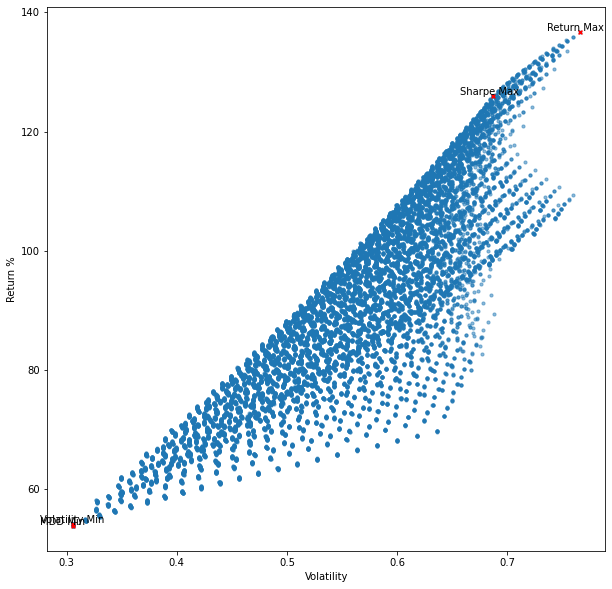

In [12]:
# Input: data/data_d.csv
# Output: 각 국면별, 위험선호도별 최적 비중
weight.Run()

In [13]:
# 7. 각 포트폴리오에 대한 백테스팅 클래스 호출
backtesting = Strategy()


전략 실행은 2003-03 부터 가능합니다. YYYY-MM 양식을 지켜주세요
전략실행 시작 연-월을 입력하세요. 월초부터 실행합니다. ex)2003-03 : 2003-03

전략 실행은 2021-05 까지 가능합니다. YYYY-MM 양식을 지켜주세요
전략실행 종료 연-월을 입력하세요. 월말까지 실행합니다. ex)2021-05 : 2021-05





코스피지수 주식 60%, 한국채 10년 20%, 한국채 5년 20%, 금 0%, 원자재 0% 포트폴리오 의 결과 
Return %: 312.2349, Sharpe: 3.6878, Volatility: 0.8467

코스피지수 주식 80%, 한국채 10년 10%, 한국채 5년 10%, 금 0%, 원자재 0% 포트폴리오 의 결과 
Return %: 385.1669, Sharpe: 3.7873, Volatility: 1.017

코스피지수 주식 100%, 한국채 10년 0%, 한국채 5년 0%, 금 0%, 원자재 0% 포트폴리오 의 결과 
Return %: 458.0989, Sharpe: 3.9476, Volatility: 1.1605

아래는 Reference인 All Weather Portfolio 입니다.
코스피지수 주식 30%, 한국채 10년 40%, 한국채 5년 15%, 금 7.5%, 원자재 7.5% 포트폴리오 의 결과 
Return %: 229.5003, Sharpe: 4.27, Volatility: 0.5375

Calculating our strategies...

전략 Risk-Averse 10-40 의 결과
Return %: 558.5502, Sharpe: 13.0397, Volatility: 0.4283

전략 Risk-Neutral 10-50 의 결과 
Return %: 682.3445, Sharpe: 14.8529, Volatility: 0.4594

전략 Risk-Lover 10-60 의 결과
Return %: 805.7911, Sharpe: 16.1954, Volatility: 0.4975



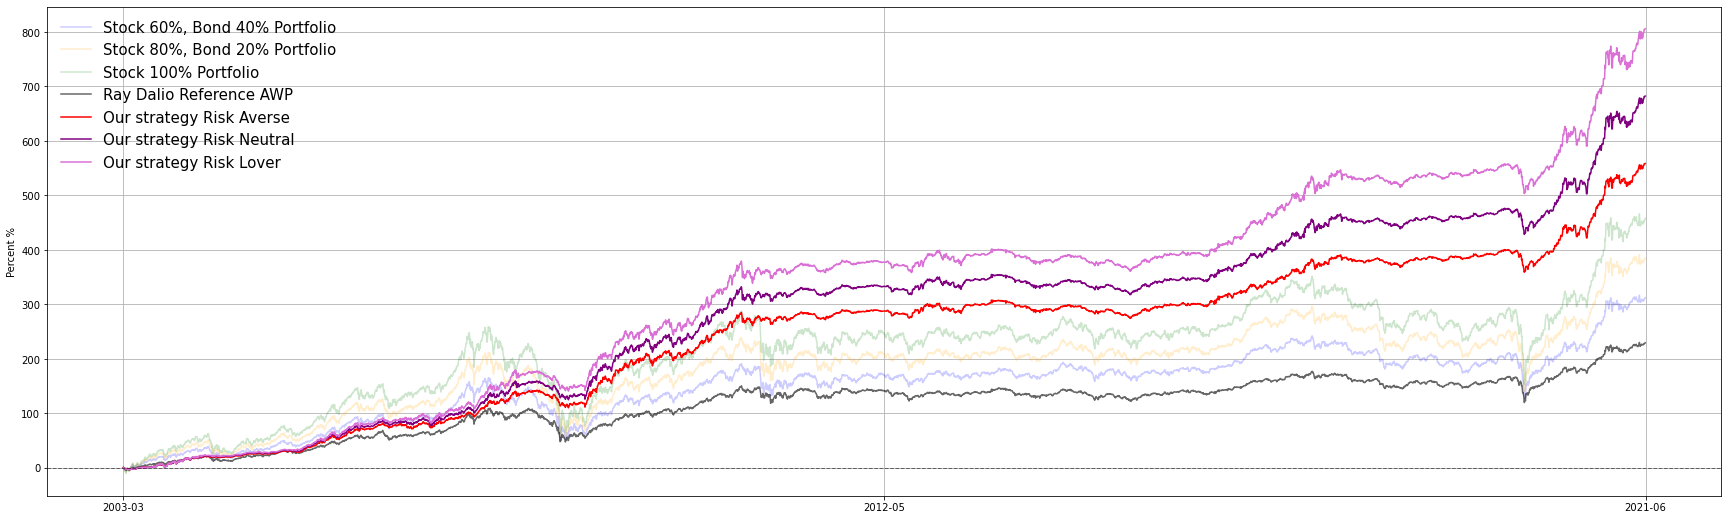

In [14]:
# Input: data/clock_data_final.csv / data_d.csv
# Output: 각 포트폴리오에 대한 백테스팅 실행
backtesting.Run()

In [15]:
# 고객 분석 클래스 호출
customer = customer_analysis()

In [16]:
# 8. K-means Clustering을 통한 타겟 고객을 설정합니다.
# 2021년 05월 거래기록이 있는 고객중 DayTrading 비중을 기준으로 K-means Clustering을 하여 타겟 고객 여부를 설정합니다.
# 고객별 위험선호도, 시장선호도, 시총선호도를 계산하고 이를 기반으로 포트폴리오 구성 ETF를 추천합니다.
# data/bigdata.csv(제공 데이터)가 필요합니다. 하단의 코드에 결과값이 저장되어 있기 때문에 이 부분을 실행하지 않아도 무방합니다.
# Input: data/bigdata.csv
# Output: data/customer_summary.csv
customer.customer_clustering()

In [17]:
# 9. 고객별 타겟 고객 여부와 위험선호도, 시장선호도, 시총선호도와 포트폴리오를 프린트합니다.
# Input: 고객번호(1~1499991)
# Output: 고객별 포트폴리오 구성 ETF
customer.customer_number(1)
customer.customer_number(5)
customer.customer_number(1499989)

1번 고객님은 AWP 타겟 고객입니다.
위험선호도: 고위험
시장선호도: 코스피
시총선호도: X
주식: 코스피
장기채: 중장기국채
중기채: 단기채권액티브
원자재: 금속선물/농산물선물/원유선물
금: 금은선물
/////////////////////////////////////
5번 고객님은 AWP 타겟 고객이 아닙니다.
/////////////////////////////////////
1499989번 고객님은 5월 거래데이터가 없어서 분석하지 못했습니다.
/////////////////////////////////////
